In [1]:
import radarsimpy
print('`RadarSimPy` used in this example is version: ' +
      str(radarsimpy.__version__))


`RadarSimPy` used in this example is version: 12.0.0


# TDM MIMO FMCW Radar

[![Documentations](https://img.shields.io/github/v/tag/radarsimx/radarsimpy?label=Documentation&logo=read-the-docs)](https://radarsimx.github.io/radarsimpy/)
[![Download](https://img.shields.io/github/v/tag/radarsimx/radarsimpy?label=Download&logo=python)](https://radarsimx.com/product/radarsimpy/)

## Introduction

Time-Division Multiplexed Multiple-Input, Multiple-Output Frequency-Modulated Continuous Wave (TDM MIMO FMCW) radar is a sophisticated radar technology that combines several advanced techniques to enhance the capabilities of radar systems. Here's a brief introduction to TDM MIMO FMCW radar:

1. **Multiple-Input, Multiple-Output (MIMO):** TDM MIMO radar utilizes multiple antennas for both transmission and reception. This MIMO configuration enables the radar to simultaneously transmit and receive multiple signals, improving the radar's performance in terms of target detection, localization, and tracking.

2. **Frequency-Modulated Continuous Wave (FMCW):** FMCW radar is characterized by its continuous transmission of frequency-modulated signals. By measuring the frequency difference between transmitted and received signals, FMCW radar can accurately determine the range and velocity of targets.

3. **Time-Division Multiplexing (TDM):** In TDM MIMO FMCW radar, the multiple antennas are employed in a time-division manner. This means that each antenna transmits and receives signals sequentially, one at a time. TDM allows for efficient utilization of the radar hardware and spectrum, reducing interference between antennas.

4. **Enhanced Spatial Resolution:** The use of multiple antennas in TDM MIMO radar enhances the system's spatial resolution, enabling it to distinguish between closely spaced targets more effectively. This is particularly valuable in applications like automotive radar and surveillance.

5. **Increased Target Detection and Tracking:** TDM MIMO FMCW radar benefits from improved target detection and tracking capabilities due to the ability to transmit multiple beams and receive signals from various angles simultaneously. This is crucial for applications requiring high accuracy and reliability.

6. **Applications:** TDM MIMO FMCW radar finds applications in a wide range of fields, including autonomous vehicles for improved perception and collision avoidance, military surveillance for target identification, and industrial applications for precise object detection and monitoring.

7. **Advanced Signal Processing:** To fully exploit the capabilities of TDM MIMO FMCW radar, advanced signal processing techniques are often employed to process the multiple received signals and extract valuable information about targets, including their positions, velocities, and sizes.

In summary, TDM MIMO FMCW radar combines the advantages of MIMO technology, FMCW radar principles, and time-division multiplexing to achieve enhanced spatial resolution, target detection, and tracking capabilities. It is a versatile radar technology with applications across various industries and domains.

This illustrative example showcases the effective utilization of channel delay and prp (pulse repetition period) for configuring a TDM MIMO radar using [`RadarSimPy`](https://radarsimx.com/radarsimx/radarsimpy/).

## Create Radar Model

Firstly, import the required modules from `radarsimpy`. `numpy` will also be needed in this example.


In [2]:
import numpy as np
from radarsimpy import Radar, Transmitter, Receiver


### MIMO Array Configuration

The transmitter array consists of 4 antenna elements with a $2\lambda$ spacing. Both of the transmitter antenna elements have the same radiation pattern $\cos{\theta}$. The gain of the transmitter antenna elements is 6 dB. For TDM configuration, `delay` parameter controls the time offset between transmitter channels.

- Tx Channel 1: 0 us delay
- Tx Channel 2: 100 us delay
- Tx Channel 3: 200 us delay
- Tx Channel 4: 300 us delay


In [3]:
wavelength = 3e8 / 24.125e9

angle = np.arange(-90, 91, 1)
pattern = 20 * np.log10(np.cos(angle / 180 * np.pi) + 0.01) + 6

tx_channel_1 = dict(location=(0, -12 * wavelength, 0),
                    azimuth_angle=angle,
                    azimuth_pattern=pattern,
                    elevation_angle=angle,
                    elevation_pattern=pattern,
                    delay=0)
tx_channel_2 = dict(location=(0, -8 * wavelength, 0),
                    azimuth_angle=angle,
                    azimuth_pattern=pattern,
                    elevation_angle=angle,
                    elevation_pattern=pattern,
                    delay=100e-6)
tx_channel_3 = dict(location=(0, -4 * wavelength, 0),
                    azimuth_angle=angle,
                    azimuth_pattern=pattern,
                    elevation_angle=angle,
                    elevation_pattern=pattern,
                    delay=200e-6)
tx_channel_4 = dict(location=(0, 0, 0),
                    azimuth_angle=angle,
                    azimuth_pattern=pattern,
                    elevation_angle=angle,
                    elevation_pattern=pattern,
                    delay=300e-6)

tx = Transmitter(f=[24.075e9, 24.175e9],
                 t=80e-6,
                 tx_power=15,
                 prp=400e-6,
                 pulses=1,
                 channels=[tx_channel_1, tx_channel_2, tx_channel_3, tx_channel_4])

### Receiver

Setup the receiver parameters through [Receiver](https://radarsimx.github.io/radarsimpy/radar.html#radarsimpy-receiver) module.

The receiver array consists of 8 antenna elements with a $\lambda /2$ spacing. All of the receiver antenna elements have the same radiation pattern $\cos{\theta}$. The gain of the receiver antenna elements is 6 dB.


In [4]:
channels = []
for idx in range(0, 8):
    channels.append(
        dict(
            location=(0, wavelength / 2 * idx, 0),
            azimuth_angle=angle,
            azimuth_pattern=pattern,
            elevation_angle=angle,
            elevation_pattern=pattern,
        ))

rx = Receiver(fs=2e6,
              noise_figure=8,
              rf_gain=20,
              baseband_gain=50,
              load_resistor=500,
              channels=channels)

### Radar System

Use the defined transmitter and receiver to create the radar system.


In [5]:
radar = Radar(transmitter=tx, receiver=rx)

### Targets

The propertities of targets are defined here. There are 3 targets in this simulation. The locations of the targets are defined through $(x, y, z)$ coordinates in meters, and the speeds of the targets are defined trough $(v_x, v_y, v_z)$ in $m/s$. The propertites of the targets also includes radar cross-section (RCS (dBsm)) and phase (degree).


In [6]:
target_1 = dict(location=(160, 0, 0), speed=(0, 0, 0), rcs=25, phase=0)
target_2 = dict(location=(80, -80, 0), speed=(0, 0, 0), rcs=20, phase=0)
target_3 = dict(location=(30, 20, 0), speed=(0, 0, 0), rcs=8, phase=0)

targets = [target_1, target_2, target_3]

## Simulate Baseband Signals

Use the `simulator.simc` module to simulate the baseband samples from the defined radar system and targets.

The output baseband data is a dict including the timestamp and baseband. Both of them are 3-D matrix:

`[channels, pulses, ADC samples]`


In [7]:
from radarsimpy.simulator import simc

data = simc(radar, targets)
timestamp = data['timestamp']
baseband = data['baseband']

_Plot TDM chirps_


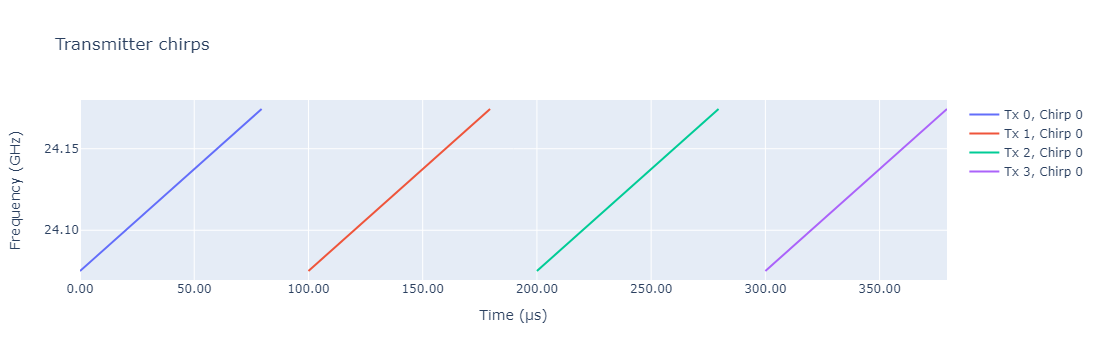

In [10]:
import plotly.graph_objs as go

fig = go.Figure()

for idx in range(0, 1):
    for ch_idx in range(0, 32, 8):
        fig.add_trace(go.Scatter(
            x=timestamp[ch_idx, idx, :] * 1e6,
            y=np.linspace(
                24.125e9 - radar.transmitter.waveform_prop["bandwidth"] / 2,
                24.125e9 + radar.transmitter.waveform_prop["bandwidth"] / 2,
                radar.samples_per_pulse,
                endpoint=False,
            ) / 1e9,
            name='Tx ' + str(int(ch_idx / 8)) + ', Chirp ' + str(idx),
        ))

fig.update_layout(
    title='Transmitter chirps',
    yaxis=dict(tickformat='.2f', title='Frequency (GHz)'),
    xaxis=dict(tickformat='.2f', title='Time (µs)'),
)

fig.show()

_Plot baseband samples_


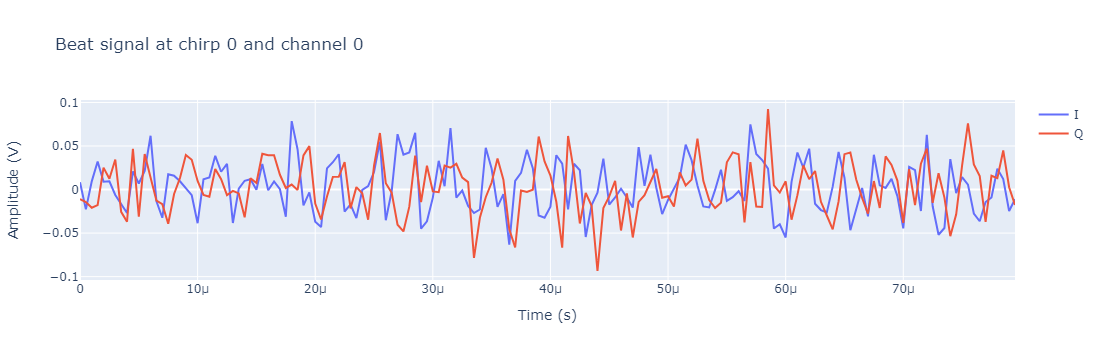

In [11]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=timestamp[0, 0, :],
    y=np.real(baseband[0, 0, :]),
    name='I',
))
fig.add_trace(go.Scatter(
    x=timestamp[0, 0, :],
    y=np.imag(baseband[0, 0, :]),
    name='Q',
))

fig.update_layout(
    title='Beat signal at chirp 0 and channel 0',
    yaxis=dict(title='Amplitude (V)'),
    xaxis=dict(title='Time (s)'),
)

fig.show()

## Radar Signal Processing

### Range Profile

With an FMCW radar, the range profile of the targets could be obtained through a simple FFT across the samples of the chirp. This process is also known as the range-FFT.


In [12]:
from scipy import signal
import radarsimpy.processing as proc

range_window = signal.windows.chebwin(radar.samples_per_pulse, at=60)
range_profile = proc.range_fft(baseband, range_window)

_Plot range profiles_


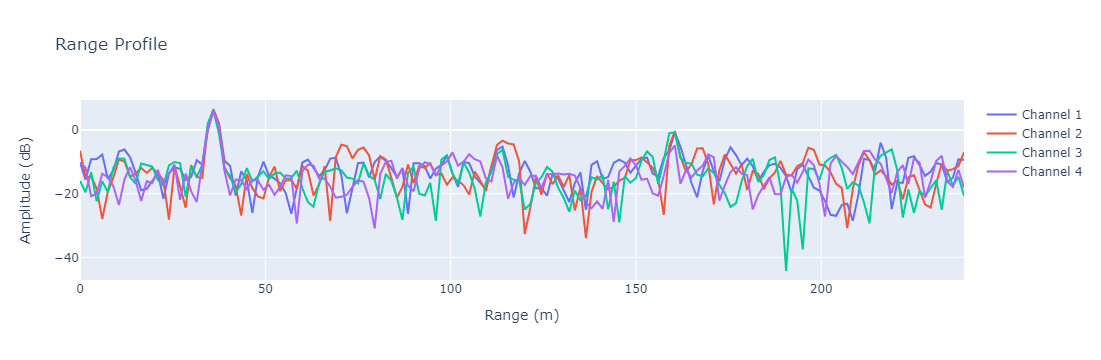

In [13]:
max_range = (3e8 * radar.receiver.bb_prop["fs"] *
             radar.transmitter.waveform_prop["pulse_length"] /
             radar.transmitter.waveform_prop["bandwidth"] / 2)
range_axis = np.linspace(
    0, max_range, radar.samples_per_pulse, endpoint=False)

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=range_axis,
    y=20 * np.log10(np.abs(range_profile[0, 0, :])),
    name='Channel 1'
))
fig.add_trace(go.Scatter(
    x=range_axis,
    y=20 * np.log10(np.abs(range_profile[8, 0, :])),
    name='Channel 2'
))
fig.add_trace(go.Scatter(
    x=range_axis,
    y=20 * np.log10(np.abs(range_profile[16, 0, :])),
    name='Channel 3'
))
fig.add_trace(go.Scatter(
    x=range_axis,
    y=20 * np.log10(np.abs(range_profile[24, 0, :])),
    name='Channel 4'
))

fig.update_layout(
    title='Range Profile',
    xaxis=dict(title='Range (m)'),
    yaxis=dict(title='Amplitude (dB)'),
)

fig.show()

### Digital Beamforming


In [14]:
azimuth = np.arange(-90, 90, 1)

array_loc_x = np.zeros((1, len(radar.virtual_array)))
for va_idx, va in enumerate(radar.virtual_array):
    array_loc_x[0, va_idx] = va[1] * 24.125e9 / 3e8

azimuth_grid, array_loc_grid = np.meshgrid(azimuth, array_loc_x)

A = np.transpose(
    np.exp(1j * 2 * np.pi * array_loc_grid *
           np.sin(azimuth_grid / 180 * np.pi)))

bf_window = np.transpose(
    np.array([signal.windows.chebwin(len(radar.virtual_array), at=50)]))
AF = np.matmul(
    A, range_profile[:, 0, :] *
    np.repeat(bf_window, radar.samples_per_pulse, axis=1))

_Plot range-angle map_


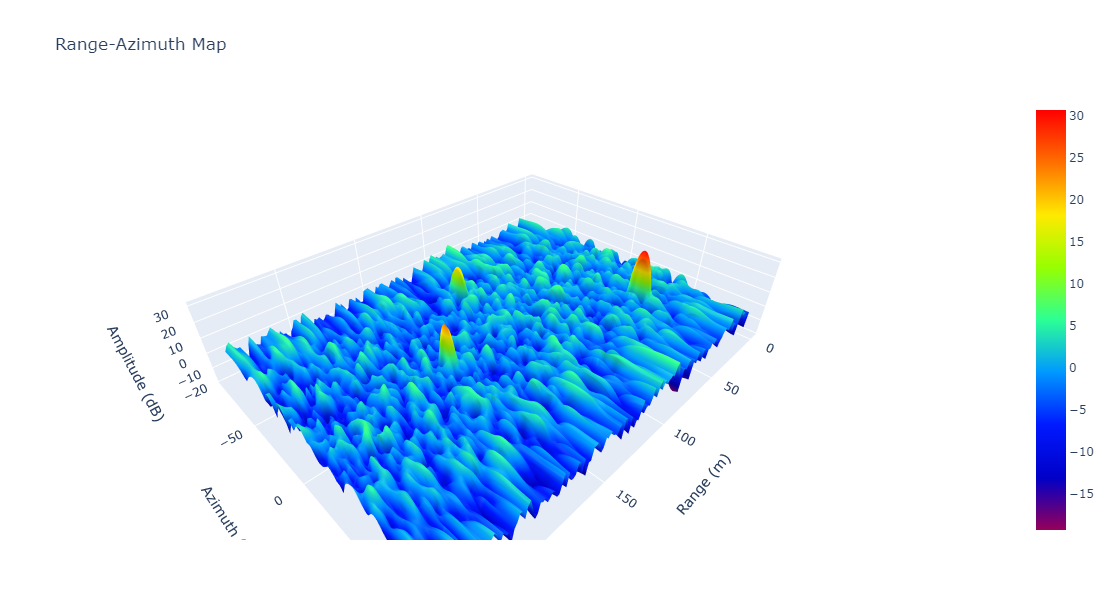

In [15]:
range_axis = np.linspace(0,
                         max_range,
                         radar.samples_per_pulse,
                         endpoint=False)

fig = go.Figure()
fig.add_trace(go.Surface(x=range_axis,
                         y=azimuth,
                         z=20 * np.log10(np.abs(AF) + 0.1),
                         colorscale='Rainbow'))

fig.update_layout(
    title='Range-Azimuth Map',
    height=600,
    scene=dict(
        xaxis=dict(title='Range (m)'),
        yaxis=dict(title='Azimuth (deg)'),
        zaxis=dict(title='Amplitude (dB)'),
        aspectmode='data',
    ),
    margin=dict(l=0, r=0, b=60, t=100),
)

fig.show()
